In [68]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import classification_report, hamming_loss
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
import mlflow
import dagshub

dagshub.init(repo_owner='Shrijeet14', repo_name='toxic-comment-classification', mlflow=True)


mlflow.set_tracking_uri("https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow")


Initialized MLflow to track repo "Shrijeet14/toxic-comment-classification"

Repository Shrijeet14/toxic-comment-classification initialized!

In [6]:
train_df = pd.read_csv("C:\\Users\\hp\\Desktop\\train.csv")
test_df = pd.read_csv("C:\\Users\\hp\\Desktop\\test.csv")
test_labels_df = pd.read_csv("C:\\Users\\hp\\Desktop\\test_labels.csv")

In [7]:
test_labels_df.drop('id' , axis=1 , inplace=True)
test_df = pd.concat([test_df , test_labels_df] , axis=1)

In [8]:
df = pd.concat([train_df , test_df] , ignore_index=True)
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
312730,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1
312731,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1
312732,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1
312733,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1


In [9]:
df.to_csv('C:\\Users\\hp\\Desktop\\full_data.csv' , index=False)

In [10]:
df = pd.read_csv('C:\\Users\\hp\\Desktop\\full_data.csv')
df.drop('id' , inplace=True , axis=1)

In [11]:
wordnet_lemmatizer = WordNetLemmatizer()

def replaceURL(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|([a-zA-z]+\.(com|net|org|co|us|me|biz)\S*))','url',text)
    return text

def replaceAbbrev(text):
    text = re.sub(r"what's", "what is ",text)    
    text = re.sub(r"\'ve", " have ",text)
    text = re.sub(r"can't", "cannot ",text)
    text = re.sub(r"n't", " not ",text)
    text = re.sub(r"i'm", "i am ",text)
    text = re.sub(r"\'re", " are ",text)
    text = re.sub(r"\'d", " would ",text)
    text = re.sub(r"\'ll", " will ",text)
    text = re.sub(r"\'scuse", " excuse ",text)
    text = re.sub(r"\'s", " ",text)
    return text

def removeUnicode(text):
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r' ', text)       
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    return text

def removeRepeatPattern(text):
    text=re.sub(r'([a-zA-Z])\1{2,}\b',r'\1\1',text)
    text=re.sub(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1',text)
    text=re.sub(r'[ ]{2,}',' ',text)
    return text

def replaceAtUser(text):
    text = re.sub('@[^\s]+','atUser',text)
    return text

def replaceMultiToxicWords(text):
    text = re.sub(r'(fuckfuck)','fuck fuck ',text)
    text = re.sub(r'(f+)( *)([u|*|_]+)( *)([c|*|_]+)( *)(k)+','fuck',text)
    text = re.sub(r'(h+)(a+)(h+)(a+)','ha ha ',text)
    text = re.sub(r'(s+ *h+ *[i|!]+ *t+)','shit',text)
    text = re.sub(r'\b(n+)(i+)(g+)(a+)\b','nigga',text)
    text = re.sub(r'\b(n+)([i|!]+)(g+)(e+)(r+)\b','nigger',text)
    text = re.sub(r'\b(d+)(o+)(u+)(c+)(h+)(e+)( *)(b+)(a+)(g+)\b','douchebag',text)
    text = re.sub(r'([a|@][$|s][s|$])','ass',text)
    text = re.sub(r'(\bfuk\b)','fuck',text)
    return text

def removeNumbers(text):
    text = re.sub("([a-zA-z])5", r"\1s", text)
    text = re.sub("5([a-zA-z])", r"s\1", text)
    text = re.sub("([a-zA-z])1", r"\1i", text)
    text = re.sub("1([a-zA-z])", r"i\1", text)
    text = re.sub("([a-zA-z])0", r"\1o", text)
    text = re.sub("0([a-zA-z])", r"o\1", text)
    text = re.sub(r"\d+", " ", text)
    return text
                  
def replaceMultiPunc(text):
    text=re.sub(r'([!])\1\1{2,}',r' mxm ',text)
    text=re.sub(r'([?])\1\1{2,}',r' mqm ',text)
    text=re.sub(r'([*])\1\1{2,}',r'*',text)
    return text


replace_pun = {}
separators = set('"%&\'()+,-./:;<=>@[\\]^_`{|}~')
for punc in separators:
    replace_pun[punc] = ' '
replace_pun['&']=' and '

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def my_cleaner(s, remove_stop_words=True):
    s = s.lower()
    s=replaceURL(s)
    s=removeUnicode(s)
    s=removeNumbers(s)
    s=replaceAbbrev(s)
    s=replaceMultiToxicWords(s)
    # replacing all whitespace/underscores with a space
    re.sub('_\n\t\r', ' ', s)
    s=replaceMultiPunc(s)
    s=removeRepeatPattern(s)
    
    for punc in separators:
        s= s.replace(punc,replace_pun[punc])                   # remove & replace punctuations
    tokens = nltk.tokenize.word_tokenize(s)                    # split a string into words (tokens)
    tokens = [wordnet_lemmatizer.lemmatize(t).lower() for t in tokens]
    if remove_stop_words:
        tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

def clean(df, col):
    df.loc[:, col] = df.loc[:, col].apply(my_cleaner)
    return df

In [12]:
# CLeaning the entire dataset 
df = clean(df , 'comment_text')

In [13]:
df.info() #312735

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312735 entries, 0 to 312734
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   312735 non-null  object
 1   toxic          312735 non-null  int64 
 2   severe_toxic   312735 non-null  int64 
 3   obscene        312735 non-null  int64 
 4   threat         312735 non-null  int64 
 5   insult         312735 non-null  int64 
 6   identity_hate  312735 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 16.7+ MB


In [14]:
df.drop_duplicates(inplace=True)

In [15]:
import numpy as np

df['category'] = np.where(
    (df['identity_hate'] == 1) | (df['insult'] == 1) | (df['threat'] == 1) | 
    (df['obscene'] == 1) | (df['severe_toxic'] == 1) | (df['toxic'] == 1), 
    -1, 
    0
)

In [16]:
# frequency distribution of sentiments

df['category'].value_counts(normalize=True).mul(100).round(2)

category
 0    92.75
-1     7.25
Name: proportion, dtype: float64

In [17]:
df['word_count'] = df['comment_text'].apply(lambda x: len(x.split()))

C:\Users\hp\AppData\Local\Temp\ipykernel_1081172\4112482658.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')


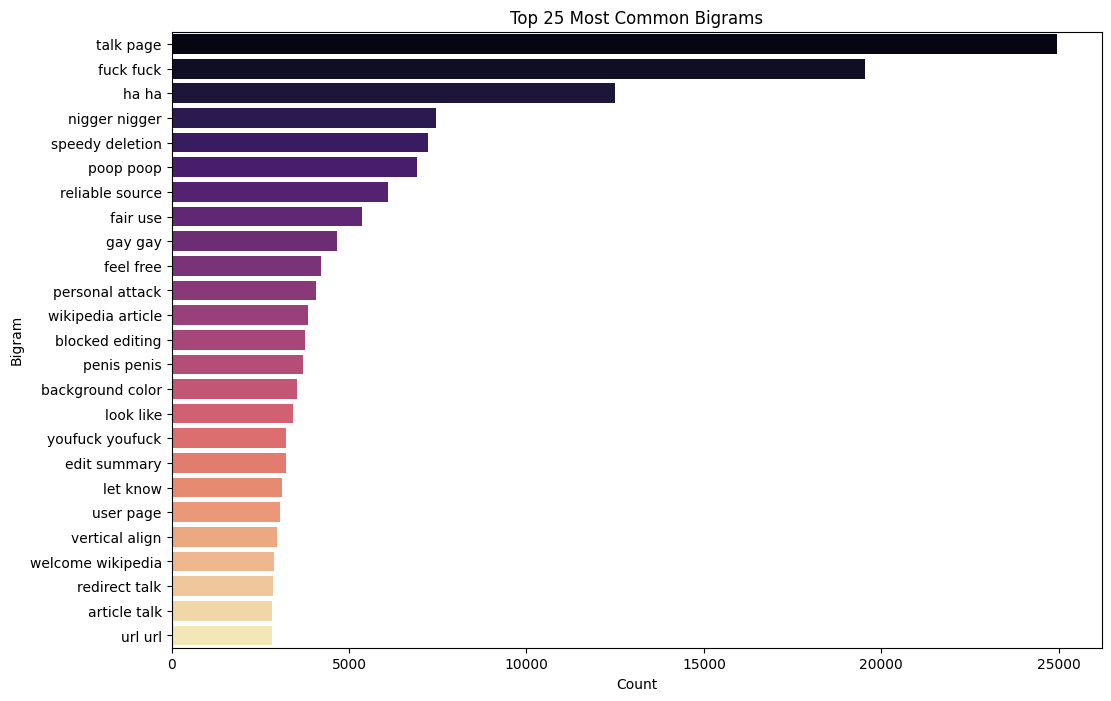

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_25_bigrams = get_top_ngrams(df['comment_text'], 25)
top_25_bigrams_df = pd.DataFrame(top_25_bigrams, columns=['bigram', 'count'])

plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')
plt.title('Top 25 Most Common Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()

In [19]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['comment_text'] = df['comment_text'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,category,word_count
0,explanation edits made username hardcore metal...,0,0,0,0,0,0,0,24
1,aww ! match background colour seemingly stuck ...,0,0,0,0,0,0,0,11
2,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,0,21
3,make real suggestion improvement wondered sect...,0,0,0,0,0,0,0,54
4,sir hero chance remember page ?,0,0,0,0,0,0,0,6


In [20]:
!pip install sentence-transformers

  Using cached torch-2.6.0-cp310-cp310-win_amd64.whl.metadata (28 kB)
  Using cached huggingface_hub-0.29.3-py3-none-any.whl.metadata (13 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached MarkupSafe-3.0.2-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
Using cached huggingface_hub-0.29.3-py3-none-any.whl (468 kB)
Using cached torch-2.6.0-cp310-cp310-win_amd64.whl (204.2 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/10.2 MB 6.3 MB/s eta 0:00:02
   -------- ------------------------------- 2.1/10.2 MB 4.7 MB/s eta 0:00:02
   ------------ --------------------------- 

In [22]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

c:\Users\hp\Desktop\toxic-comment-classification\venv\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hp\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [23]:
vectors = df['comment_text'].apply(lambda x: model.encode(x))
vectors = np.array(vectors.tolist())

In [62]:
label = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# df[label] = df[label].astype(int)

In [41]:
vectors_df = pd.DataFrame(vectors, columns=[f'vector_{i}' for i in range(vectors.shape[1])])
final_df = pd.concat([vectors_df, df[label].reset_index(drop=True)], axis=1)

final_df.to_csv("hate_speech_dataset.csv", index=False)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(vectors, df[label], test_size=0.2, random_state=42)

In [69]:
label_encoder = LabelEncoder()
y_train = y_train.apply(lambda col: label_encoder.fit_transform(col))
y_test = y_test.apply(lambda col: label_encoder.transform(col))

In [70]:
param_grid = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [3, 6],
    'estimator__learning_rate': [0.01, 0.1]
}

In [71]:
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
multi_xgb = MultiOutputClassifier(xgb)
clf = GridSearchCV(multi_xgb, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)

In [72]:
mlflow.set_experiment("Embedding model with XGB")

<Experiment: artifact_location='mlflow-artifacts:/2ddb5157734c498cabc81a99e2c81393', creation_time=1743247877162, experiment_id='5', last_update_time=1743247877162, lifecycle_stage='active', name='Embedding model with XGB', tags={}>

In [74]:
with mlflow.start_run():
    param_list = list(ParameterGrid(param_grid))
    for i, params in enumerate(tqdm(param_list, desc="Training Models")):
        print(f"Training model {i+1}/{len(param_list)} with params: {params}")
        with mlflow.start_run(nested=True):
            multi_xgb.set_params(**params)
            multi_xgb.fit(X_train, y_train)
            y_pred = multi_xgb.predict(X_test)
            hl = hamming_loss(y_test, y_pred)
            report = classification_report(y_test, y_pred, target_names=y.columns, output_dict=True)
            mlflow.log_params(params)
            mlflow.log_metric("hamming_loss", hl)

    print("Running GridSearchCV for best model...")
    best_model = clf.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    best_hl = hamming_loss(y_test, y_pred)
    best_report = classification_report(y_test, y_pred, target_names=y.columns, output_dict=True)
    mlflow.log_params(best_model.best_params_)
    mlflow.log_metric("best_hamming_loss", best_hl)
    mlflow.sklearn.log_model(best_model, "xgboost_model")

    f1_scores = [best_report[label]["f1-score"] for label in y.columns]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=y.columns, y=f1_scores, palette="viridis")
    plt.xlabel("Labels")
    plt.ylabel("F1 Score")
    plt.title("F1 Score per Label")
    plt.xticks(rotation=45)
    plt.savefig("f1_scores.png")
    mlflow.log_artifact("f1_scores.png")
    mlflow.end_run()


Training Models:   0%|          | 0/8 [00:00<?, ?it/s]

Training model 1/8 with params: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 100}


c:\Users\hp\Desktop\toxic-comment-classification\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [17:21:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hp\Desktop\toxic-comment-classification\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [17:22:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hp\Desktop\toxic-comment-classification\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hp\Desktop\toxic-comment-classification\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [17:26:13] WARNING: C:\actions-r

🏃 View run popular-cub-604 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/5/runs/daa4efd08ae14fe099aae56654af6282
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/5


Training Models:   0%|          | 0/8 [11:12<?, ?it/s]


🏃 View run luxuriant-roo-617 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/5/runs/9397dc5e451b4363b00eb9a201c2fb49
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/5


ValueError: multiclass-multioutput is not supported

In [ ]:
# with mlflow.start_run():
#     param_list = list(ParameterGrid(param_grid))
#     for i, params in enumerate(tqdm(param_list, desc="Training Models")):
#         print(f"Training model {i+1}/{len(param_list)} with params: {params}")
#         with mlflow.start_run(nested=True):
#             multi_xgb.set_params(**params)
#             multi_xgb.fit(X_train, y_train)
#             y_pred = multi_xgb.predict(X_test)
#             hl = hamming_loss(y_test, y_pred)
#             report = classification_report(y_test, y_pred, target_names=y.columns, output_dict=True)
#             mlflow.log_params(params)
#             mlflow.log_metric("hamming_loss", hl)
    
#     print("Running GridSearchCV for best model...")
#     best_model = clf.fit(X_train, y_train)
#     y_pred = best_model.predict(X_test)
#     best_hl = hamming_loss(y_test, y_pred)
#     best_report = classification_report(y_test, y_pred, target_names=y.columns, output_dict=True)
#     mlflow.log_params(best_model.best_params_)
#     mlflow.log_metric("best_hamming_loss", best_hl)
#     mlflow.sklearn.log_model(best_model, "xgboost_model")
    
#     f1_scores = [best_report[label]["f1-score"] for label in y.columns]
#     plt.figure(figsize=(10, 5))
#     sns.barplot(x=y.columns, y=f1_scores, palette="viridis")
#     plt.xlabel("Labels")
#     plt.ylabel("F1 Score")
#     plt.title("F1 Score per Label")
#     plt.xticks(rotation=45)
#     plt.savefig("f1_scores.png")
#     mlflow.log_artifact("f1_scores.png")
#     mlflow.end_run()


Training Models:   0%|          | 0/8 [00:00<?, ?it/s]

Training model 1/8 with params: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 100}


c:\Users\hp\Desktop\toxic-comment-classification\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [17:01:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hp\Desktop\toxic-comment-classification\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [17:04:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hp\Desktop\toxic-comment-classification\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [17:05:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hp\Desktop\toxic-comment-classification\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [17:06:55] WARNING: C:\actions-r

🏃 View run brawny-rat-971 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/5/runs/9bbad398a79d44689e7c01a07fac6dca
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/5


Training Models:   0%|          | 0/8 [09:46<?, ?it/s]


🏃 View run angry-kite-993 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/5/runs/5ffd70e8052a41289aadc37ec6d00ccf
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/5


ValueError: multiclass-multioutput is not supported

: 